In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Preuzimanje potrebnih NLTK resursa
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

df = pd.read_csv('train.csv')

print(df.head())


   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Prikaz distribucije podataka

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kreiraj novu kolonu 'label' za binarnu klasifikaciju
df['label'] = df['class'].apply(lambda x: 1 if x == 1 else 0)
def plot_distribution(data, column):
# Prikaži distribuciju klasa
    class_counts = data[column].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribucija klasa')
    plt.xlabel('Klasa (0 = Nije govor mržnje, 1 = Govor mržnje)')
    plt.ylabel('Broj primera')
    plt.show()

In [4]:
df = df[['tweet', 'label']]

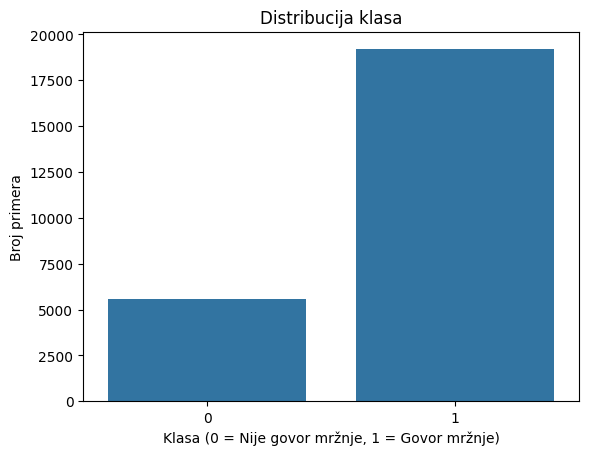

In [5]:
plot_distribution(df, 'label')

#### Preprocesiranje teksta

In [6]:
def preprocess_text(df, text_column):
    """
    Funkcija za predobradu teksta.
    
    Argumenti:
    - df: Pandas DataFrame koji sadrži kolonu sa tekstom.
    - text_column: Ime kolone koja sadrži tekstualne podatke.
    
    Vraća:
    - df: Pandas DataFrame sa novom kolonom 'clean_text' koja sadrži predobrađen tekst.
    """
    # Kopiramo originalni DataFrame da ne bismo menjali originalne podatke
    df = df.copy()
    
    # Uklanjanje URL-ova i email adresa
    df['clean_tweet'] = df[text_column].apply(lambda x: re.sub(r'http\S+|www.\S+|mailto:\S+', '', x))
    
    # Uklanjanje HTML tagova
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
    
    # Uklanjanje emotikona i specijalnih karaktera
    def remove_emojis(text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emotikoni
                                   u"\U0001F300-\U0001F5FF"  # simobli i ikone
                                   u"\U0001F680-\U0001F6FF"  # transport i simobli
                                   u"\U0001F1E0-\U0001F1FF"  # zastave
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    df['clean_tweet'] = df['clean_tweet'].apply(remove_emojis)
    
    # Uklanjanje specijalnih karaktera i interpunkcije
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^A-Za-zšđčćžŠĐČĆŽ ]+', ' ', x))
    
    # Pretvaranje u mala slova
    df['clean_tweet'] = df['clean_tweet'].str.lower()
    
    # Uklanjanje dijakritika
    def remove_diacritics(text):
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        return text

    df['clean_tweet'] = df['clean_tweet'].apply(remove_diacritics)
    
    # Uklanjanje višestrukih razmaka
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('\s+', ' ', x).strip())
    
    # Tokenizacija
    df['tokens'] = df['clean_tweet'].apply(nltk.word_tokenize)
    
    # Uklanjanje stop-reči
    stop_words = set(stopwords.words('english'))  # Ako imaš stop-reči za srpski, zameni ovde
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Lematizacija
    lemmatizer = WordNetLemmatizer()
    df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # Spajanje tokena nazad u string
    df['clean_tweet'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    # Uklanjanje nepotrebnih kolona
    df = df.drop(columns=['tokens'])
    
    return df


In [7]:
data = preprocess_text(df, 'tweet')

print(data)

C:\Users\Kaca\AppData\Local\Temp\ipykernel_21012\2996977020.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['clean_tweet'] = df['clean_tweet'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())


                                                   tweet  label  \
0      !!! RT @mayasolovely: As a woman you shouldn't...      0   
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1   
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1   
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1   
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1   
...                                                  ...    ...   
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...      1   
24779  you've gone and broke the wrong heart baby, an...      0   
24780  young buck wanna eat!!.. dat nigguh like I ain...      1   
24781              youu got wild bitches tellin you lies      1   
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      0   

                                             clean_tweet  
0      rt mayasolovely woman complain cleaning house ...  
1      rt mleew boy dat cold tyga dwn bad cuffin dat ...  
2      rt urkindof

#### Definisanje metoda mašinskog učenja

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_logistic_regression(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Logistička regresija:")
    print(classification_report(y_test, y_pred))
    return model

def train_svm(X_train, y_train, X_test, y_test):
    from sklearn.svm import SVC
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("SVM:")
    print(classification_report(y_test, y_pred))
    return model

def train_naive_bayes(X_train, y_train, X_test, y_test):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Naivni Bajes:")
    print(classification_report(y_test, y_pred))
    return model


#### Definisanje neuronskih mreža

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout

def prepare_tokenizer(texts, num_words=5000):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def tokenize_and_pad(tokenizer, texts, maxlen=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen)
    return padded

def train_lstm(X_train, y_train, X_test, y_test, vocab_size, maxlen=100):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'LSTM Test Accuracy: {accuracy}')
    return model

def train_cnn(X_train, y_train, X_test, y_test, vocab_size, maxlen=100):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'CNN Test Accuracy: {accuracy}')
    return model


#### Definisanje BERT modela

In [10]:

from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

def train_bert(X_train, y_train, X_test, y_test, model_name='bert-base-multilingual-cased', epochs=3):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    
    # Tokenizacija i enkodiranje
    def encode_texts(texts):
        return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='tf')
    
    train_encodings = encode_texts(X_train)
    test_encodings = encode_texts(X_test)
    
    # Konvertovanje labela u tensor
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)
    
    # Kreiranje TensorFlow dataset-a
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))
    
    # Batchevi
    train_dataset = train_dataset.shuffle(len(X_train)).batch(8)
    test_dataset = test_dataset.batch(8)
    
    # Model
    model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    # Kompajliranje modela
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
    
    # Treniranje modela
    model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)
    
    # Evaluacija
    loss, accuracy = model.evaluate(test_dataset)
    print(f'BERT Test Accuracy: {accuracy}')
    return model


RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test, model_type='sklearn', tokenizer=None, maxlen=100):
    """
    Evaluira model i prikazuje metrike performansi.
    
    Argumenti:
    - model: istrenirani model
    - X_test: test podaci (tekstualni ili vektorski)
    - y_test: stvarne labela
    - model_type: 'sklearn', 'keras', ili 'bert'
    - tokenizer: Tokenizer objekat (potreban za neuronske mreže)
    - maxlen: maksimalna dužina sekvenci (za neuronske mreže)
    """
    if model_type == 'sklearn':
        y_pred = model.predict(X_test)
    elif model_type == 'keras':
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
    elif model_type == 'bert':
        y_pred = model.predict(X_test).logits
        y_pred = np.argmax(y_pred, axis=1)
    else:
        raise ValueError("Nepoznat tip modela.")
    
    print("Izveštaj o klasifikaciji:")
    print(classification_report(y_test, y_pred))
    print("Matrica konfuzije:")
    print(confusion_matrix(y_test, y_pred))


### Primena algoritama nad originalnim podacima

In [12]:
X = data['clean_tweet']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.4. Vektorizacija za klasične modele
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 4.7. Tokenizacija za neuronske mreže
tokenizer = prepare_tokenizer(X_train, num_words=5000)
X_train_seq = tokenize_and_pad(tokenizer, X_train)
X_test_seq = tokenize_and_pad(tokenizer, X_test)
vocab_size = len(tokenizer.word_index) + 1  # +1 za rezervisani indeks 0

# 4.12. Treniranje BERT modela
# bert_model = train_bert(X_train.tolist(), y_train.tolist(), X_test.tolist(), y_test.tolist(), model_name='distilbert-base-multilingual-cased')

In [13]:
lr_model = train_logistic_regression(X_train_vec, y_train, X_test_vec, y_test)
evaluate_model(lr_model, X_test_vec, y_test, model_type='sklearn')

Logistička regresija:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1125
           1       0.92      0.95      0.93      3832

    accuracy                           0.90      4957
   macro avg       0.86      0.83      0.85      4957
weighted avg       0.89      0.90      0.89      4957

Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1125
           1       0.92      0.95      0.93      3832

    accuracy                           0.90      4957
   macro avg       0.86      0.83      0.85      4957
weighted avg       0.89      0.90      0.89      4957

Matrica konfuzije:
[[ 811  314]
 [ 197 3635]]


In [14]:
svm_model = train_svm(X_train_vec, y_train, X_test_vec, y_test)
evaluate_model(svm_model, X_test_vec, y_test, model_type='sklearn')

SVM:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1125
           1       0.93      0.95      0.94      3832

    accuracy                           0.90      4957
   macro avg       0.87      0.85      0.86      4957
weighted avg       0.90      0.90      0.90      4957

Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1125
           1       0.93      0.95      0.94      3832

    accuracy                           0.90      4957
   macro avg       0.87      0.85      0.86      4957
weighted avg       0.90      0.90      0.90      4957

Matrica konfuzije:
[[ 845  280]
 [ 205 3627]]


In [15]:
nb_model = train_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
evaluate_model(nb_model, X_test_vec, y_test, model_type='sklearn')

Naivni Bajes:
              precision    recall  f1-score   support

           0       0.87      0.37      0.52      1125
           1       0.84      0.98      0.91      3832

    accuracy                           0.84      4957
   macro avg       0.86      0.68      0.71      4957
weighted avg       0.85      0.84      0.82      4957

Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.87      0.37      0.52      1125
           1       0.84      0.98      0.91      3832

    accuracy                           0.84      4957
   macro avg       0.86      0.68      0.71      4957
weighted avg       0.85      0.84      0.82      4957

Matrica konfuzije:
[[ 415  710]
 [  62 3770]]


In [16]:
lstm_model = train_lstm(X_train_seq, y_train, X_test_seq, y_test, vocab_size)
evaluate_model(lstm_model, X_test_seq, y_test, model_type='keras')

c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 63s 187ms/step - accuracy: 0.8275 - loss: 0.3923 - val_accuracy: 0.9072 - val_loss: 0.2442
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 85s 197ms/step - accuracy: 0.9243 - loss: 0.2144 - val_accuracy: 0.9046 - val_loss: 0.2609
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 66s 214ms/step - accuracy: 0.9425 - loss: 0.1712 - val_accuracy: 0.8997 - val_loss: 0.2638
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.9505 - loss: 0.1499 - val_accuracy: 0.9001 - val_loss: 0.2845
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 241ms/step - accuracy: 0.9550 - loss: 0.1243 - val_accuracy: 0.8921 - val_loss: 0.3321
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8957 - loss: 0.3286
LSTM Test Accuracy: 0.8920718431472778
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1125
           1       0.91      0.95      0.93      3832

   

In [17]:
cnn_model = train_cnn(X_train_seq, y_train, X_test_seq, y_test, vocab_size)
evaluate_model(cnn_model, X_test_seq, y_test, model_type='keras')

Epoch 1/5


c:\Users\Kaca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.8415 - loss: 0.3849 - val_accuracy: 0.9030 - val_loss: 0.2517
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.9273 - loss: 0.2064 - val_accuracy: 0.8951 - val_loss: 0.2613
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.9492 - loss: 0.1493 - val_accuracy: 0.8884 - val_loss: 0.3304
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.9725 - loss: 0.0869 - val_accuracy: 0.8765 - val_loss: 0.4004
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.9848 - loss: 0.0486 - val_accuracy: 0.8703 - val_loss: 0.5020
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8672 - loss: 0.4951
CNN Test Accuracy: 0.8702844381332397
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1125
           1       0.90      0.93      0.92      3832

    accuracy     

### Augmentacija podataka

In [ ]:
# # Definisanje metoda za prve dve kombinacije
# # methods_set1 = [synonym_replacement, random_insertion, back_translation_cached]
# # methods_set2 = [simulate_typos, back_translation, bert_augmentation]

# # OVO RADI
# # FUNKCIJE KOJE KORISTE LOCKING GA BLOKIRAJU
# # Ciljani broj instanci u negativnoj klasi (balansiranje)
# positive_count = data[data['label'] == 1].shape[0]
# print(f"Broj pozitivnih instanci (label=1): {positive_count}")

# # Treniranje augmentacije na set1
# print("\nAugmentacija - Set 1:")
# df_augmented_set1_parallel = augment_negative_class_parallel(
#     data, 
#     text_column='clean_tweet', 
#     label_column='label', 
#     methods=[back_translation_cached, random_character_swap], 
#     target_count=positive_count, 
#     max_workers=8  # Podesi broj radnika prema dostupnim resursima
# )

### Importovanje potrebnih biblioteka

In [ ]:
import pandas as pd
import numpy as np
import random
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from googletrans import Translator
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer
from tqdm import tqdm

# Preuzimanje potrebnih NLTK resursa
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


### Definisanje metoda augmentacije podataka

#### Metode augmentacije na nivou karaktera

In [27]:
def simulate_spelling_errors(text, error_prob=0.1):
    """
    Simulira pravopisne greške u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti izmenjen.
    
    Vraća:
    - Tekst sa simuliranim pravopisnim greškama.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    result = ''
    for c in text:
        if c.lower() in letters and random.random() < error_prob:
            result += random.choice(letters)
        else:
            result += c
    return result


In [28]:
def keyboard_augmenter(text, error_prob=0.1):
    """
    Simulira greške u kucanju na osnovu rasporeda tastature.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti zamenjen.
    
    Vraća:
    - Tekst sa simuliranim greškama u kucanju.
    """
    keyboard_neighbors = {
        'a': 'qwsz',
        'b': 'vghn',
        'c': 'xdfv',
        'd': 'ersfcx',
        'e': 'wsdfr',
        'f': 'rtgdvc',
        'g': 'tyfhvb',
        'h': 'yugjbn',
        'i': 'ujklo',
        'j': 'uikhmn',
        'k': 'ijolm,',
        'l': 'kop;.',
        'm': 'njk,',
        'n': 'bhjm',
        'o': 'iklp',
        'p': 'ol;',
        'q': 'wa',
        'r': 'edft',
        's': 'wedxz',
        't': 'rfgy',
        'u': 'yhji',
        'v': 'cfgb',
        'w': 'qase',
        'x': 'zsdc',
        'y': 'tghu',
        'z': 'asx'
    }
    result = ''
    for c in text:
        lower_c = c.lower()
        if lower_c in keyboard_neighbors and random.random() < error_prob:
            result += random.choice(keyboard_neighbors[lower_c])
        else:
            result += c
    return result


In [29]:
def ocr_simulation(text, error_prob=0.05):
    """
    Simulira OCR greške u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti zamenjen.
    
    Vraća:
    - Tekst sa simuliranim OCR greškama.
    """
    ocr_errors = {
        '0': ['O', 'o'],
        '1': ['I', 'l'],
        'l': ['1', 'I'],
        'O': ['0', 'o'],
        'o': ['0', 'O'],
        'I': ['1', 'l']
    }
    result = ''
    for c in text:
        if c in ocr_errors and random.random() < error_prob:
            result += random.choice(ocr_errors[c])
        else:
            result += c
    return result


In [30]:
def random_character_augmentation(text, aug_prob=0.1):
    """
    Nasumična augmentacija karaktera u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - aug_prob: Verovatnoća da će svaka operacija biti primenjena na karakter.
    
    Vraća:
    - Augmentirani tekst.
    """
    functions = [delete_random_char, substitute_random_char, swap_random_chars, insert_random_char]
    augmented_text = text
    for func in functions:
        augmented_text = func(augmented_text, aug_prob)
    return augmented_text

def delete_random_char(text, aug_prob):
    result = ''
    for c in text:
        if random.random() > aug_prob:
            result += c
    return result

def substitute_random_char(text, aug_prob):
    letters = string.ascii_letters
    result = ''
    for c in text:
        if random.random() < aug_prob:
            result += random.choice(letters)
        else:
            result += c
    return result

def swap_random_chars(text, aug_prob):
    text = list(text)
    for i in range(len(text)-1):
        if random.random() < aug_prob:
            text[i], text[i+1] = text[i+1], text[i]
    return ''.join(text)

def insert_random_char(text, aug_prob):
    result = ''
    letters = string.ascii_letters
    for c in text:
        result += c
        if random.random() < aug_prob:
            result += random.choice(letters)
    return result


#### Metode augmentacije na nivou reči

In [31]:
def synonym_replacement(text, n=2):
    """
    Zamenjuje n reči njihovim sinonimima.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    
    Vraća:
    - Tekst sa zamenjenim sinonimima.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    augmented_text = ' '.join(new_words)
    return augmented_text

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            synonym = lem.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)


In [32]:
def antonym_replacement(text, n=2):
    """
    Zamenjuje n reči njihovim antonimima.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    
    Vraća:
    - Tekst sa zamenjenim antonimima.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        antonyms = get_antonyms(random_word)
        if len(antonyms) >= 1:
            antonym = random.choice(antonyms)
            new_words = [antonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    augmented_text = ' '.join(new_words)
    return augmented_text

def get_antonyms(word):
    antonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            for ant in lem.antonyms():
                antonym = ant.name().replace('_', ' ').lower()
                antonyms.add(antonym)
    return list(antonyms)


In [33]:
def random_insertion(text, n=2):
    """
    Umeće n sinonima nasumično u tekst.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti umetnute.
    
    Vraća:
    - Tekst sa umetnutim rečima.
    """
    words = text.split()
    for _ in range(n):
        add_word(words)
    augmented_text = ' '.join(words)
    return augmented_text

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
    if len(synonyms) >= 1:
        synonym = random.choice(synonyms)
        random_idx = random.randint(0, len(words))
        words.insert(random_idx, synonym)


In [34]:
def random_swap(text, n=2):
    """
    Menja mesta dvema rečima u tekstu n puta.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj zamena.
    
    Vraća:
    - Tekst sa zamenjenim rečima.
    """
    words = text.split()
    for _ in range(n):
        words = swap_word(words)
    augmented_text = ' '.join(words)
    return augmented_text

def swap_word(words):
    idx1 = random.randint(0, len(words)-1)
    idx2 = random.randint(0, len(words)-1)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words


In [35]:
def random_deletion(text, p=0.2):
    """
    Briše reči iz teksta sa verovatnoćom p.
    
    Argumenti:
    - text: Originalni tekst.
    - p: Verovatnoća brisanja reči.
    
    Vraća:
    - Tekst sa obrisanim rečima.
    """
    words = text.split()
    if len(words) == 1:
        return text
    new_words = []
    for word in words:
        if random.uniform(0,1) > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words)
    else:
        return ' '.join(new_words)


In [36]:
def split_augmentation(text, n=2):
    """
    Deli n reči na manje delove.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti podeljene.
    
    Vraća:
    - Tekst sa podeljenim rečima.
    """
    words = text.split()
    new_words = words.copy()
    num_splits = 0
    while num_splits < n:
        idx = random.randint(0, len(new_words)-1)
        word = new_words[idx]
        if len(word) > 1:
            split_point = random.randint(1, len(word)-1)
            new_words[idx:idx+1] = [word[:split_point], word[split_point:]]
            num_splits += 1
        if num_splits >= n:
            break
    return ' '.join(new_words)


In [37]:
def spelling_augmentation(text, error_prob=0.1):
    """
    Umeće pravopisne greške u reči.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će reč biti izmenjena.
    
    Vraća:
    - Tekst sa pravopisnim greškama.
    """
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < error_prob:
            new_word = random_character_augmentation(word, aug_prob=0.2)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


In [ ]:
from gensim.models import KeyedVectors

# Učitajte pretrenirane rečničke vektore (npr. GloVe ili Word2Vec)
# Ovaj primer koristi Google pretrenirani Word2Vec model (mora biti preuzet)
# word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

def embedding_replacement(text, n=2, word_vectors=None):
    """
    Zamenjuje reči sličnim rečima na osnovu embeddinga.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    - word_vectors: Pretrenirani model rečničkih vektora.
    
    Vraća:
    - Tekst sa zamenjenim rečima.
    """
    if word_vectors is None:
        raise ValueError("word_vectors model must be provided")
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        if word in word_vectors:
            similar_words = [w for w, sim in word_vectors.most_similar(word)]
            if similar_words:
                similar_word = random.choice(similar_words)
                new_words = [similar_word if w == word else w for w in new_words]
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)


In [39]:
def contextual_embedding_augmentation(text, mask_token='[MASK]', top_k=5):
    """
    Zamenjuje reči koristeći kontekstualne modele (npr. BERT).
    
    Argumenti:
    - text: Originalni tekst.
    - mask_token: Token koji se koristi za maskiranje (default: '[MASK]').
    - top_k: Broj najboljih predikcija za izbor.
    
    Vraća:
    - Tekst sa zamenjenim rečima.
    """
    unmasker = pipeline('fill-mask', model='bert-base-uncased')
    words = text.split()
    num_masks = max(1, int(0.15 * len(words)))
    masked_indices = random.sample(range(len(words)), num_masks)
    for idx in masked_indices:
        original_word = words[idx]
        words[idx] = mask_token
        masked_text = ' '.join(words)
        predictions = unmasker(masked_text)
        for pred in predictions[:top_k]:
            new_word = pred['token_str']
            if new_word != original_word:
                words[idx] = new_word
                break
        else:
            words[idx] = original_word
    return ' '.join(words)


#### Metode augmentacije na nivu fraza i rečenica

In [40]:
def paraphrase_text(text, model=None, tokenizer=None, device='cpu'):
    """
    Parafrazira tekst koristeći T5 model.
    
    Argumenti:
    - text: Originalni tekst.
    - model: Pretrenirani T5 model.
    - tokenizer: T5 tokenizer.
    - device: 'cpu' ili 'cuda'.
    
    Vraća:
    - Parafrazirani tekst.
    """
    if model is None or tokenizer is None:
        model = T5ForConditionalGeneration.from_pretrained('t5-base')
        tokenizer = T5Tokenizer.from_pretrained('t5-base')
        model = model.to(device)
    input_text = "paraphrase: " + text + " </s>"
    encoding = tokenizer.encode_plus(input_text, padding='longest', return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        max_length=256,
        do_sample=True,
        top_k=120,
        top_p=0.95,
        early_stopping=True,
        num_return_sequences=1
    )
    paraphrased_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return paraphrased_text


In [18]:
def back_translation(text, src_language='en', target_language='de'):
    """
    Back-Translation metode.
    
    Argumenti:
    - text: Originalni tekst.
    - src_language: Izvorni jezik.
    - target_language: Ciljni jezik za prevođenje.
    
    Vraća:
    - Back-translated tekst.
    """
    translator = Translator()
    translated = translator.translate(text, src=src_language, dest=target_language).text
    back_translated = translator.translate(translated, src=target_language, dest=src_language).text
    return back_translated


In [42]:
def random_sentence_augmentation(text):
    """
    Nasumično menja redosled rečenica u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    
    Vraća:
    - Tekst sa promenjenim redosledom rečenica.
    """
    sentences = nltk.sent_tokenize(text)
    random.shuffle(sentences)
    return ' '.join(sentences)


In [43]:
def generate_text_gpt2(prompt, max_length=50):
    """
    Generiše tekst koristeći GPT-2 model.
    
    Argumenti:
    - prompt: Početni tekst.
    - max_length: Maksimalna dužina generisanog teksta.
    
    Vraća:
    - Generisani tekst.
    """
    generator = pipeline('text-generation', model='gpt2')
    outputs = generator(prompt, max_length=max_length, num_return_sequences=1)
    return outputs[0]['generated_text']


#### Primena metoda nad augmentiranim podacima

In [44]:
def augment_dataset(df, text_column, method, num_augmented_instances, **kwargs):
    """
    Primeni izabranu metodu augmentacije na dataset.
    
    Argumenti:
    - df: Originalni DataFrame.
    - text_column: Naziv kolone sa tekstom.
    - method: Funkcija metode augmentacije.
    - num_augmented_instances: Broj instanci koje treba generisati.
    - **kwargs: Dodatni argumenti za metodu augmentacije.
    
    Vraća:
    - DataFrame sa augmentiranim podacima.
    """
    augmented_texts = []
    indices = df.index.tolist()
    num_samples = len(indices)
    
    # Ako je broj instanci veći od broja dostupnih uzoraka, uzmi uzorke sa zamjenom
    replace = num_augmented_instances > num_samples
    sampled_indices = np.random.choice(indices, size=num_augmented_instances, replace=replace)
    
    for idx in tqdm(sampled_indices, desc=f'Augmenting with {method.__name__}'):
        original_text = df.loc[idx, text_column]
        augmented_text = method(original_text, **kwargs)
        augmented_texts.append(augmented_text)
    
    augmented_df = pd.DataFrame({text_column: augmented_texts})
    return augmented_df


In [ ]:
# Definiši broj instanci koje želiš da generišeš
num_instances = 20
methods = [simulate_spelling_errors, keyboard_augmenter, ocr_simulation, random_character_augmentation, synonym_replacement, antonym_replacement, random_insertion, random_swap, random_deletion, split_augmentation, spelling_augmentation, back_translation, random_sentence_augmentation]

augmented_df_synonyms = augment_dataset(
    data, 
    text_column='clean_tweet', 
    method=synonym_replacement, 
    num_augmented_instances=num_instances, 
    n=2  # Broj reči koje će biti zamenjene
)

# for method in methods:
#     augmented_df = augment_dataset(
#     data, 
#     text_column='clean_tweet', 
#     method=method, 
#     num_augmented_instances=num_instances
#             )
#     print("Method: ", method)
#     print(augmented_df, '\n\n')


In [54]:
df_augmented_set1 = data

In [ ]:
# Predobrada nije potrebna jer smo već očistili tekst

# Podela na trening i test skup
X_aug1 = df_augmented_set1['clean_tweet']
y_aug1 = df_augmented_set1['label']

X_train_aug1, X_test_aug1, y_train_aug1, y_test_aug1 = train_test_split(X_aug1, y_aug1, test_size=0.2, random_state=42)


In [ ]:
vectorizer_aug1 = TfidfVectorizer(max_features=5000)
X_train_vec_aug1 = vectorizer_aug1.fit_transform(X_train_aug1)
X_test_vec_aug1 = vectorizer_aug1.transform(X_test_aug1)


In [ ]:
# Logistička regresija
lr_model_aug1 = train_logistic_regression(X_train_vec_aug1, y_train_aug1, X_test_vec_aug1, y_test_aug1)

# SVM
svm_model_aug1 = train_svm(X_train_vec_aug1, y_train_aug1, X_test_vec_aug1, y_test_aug1)

# Naivni Bajes
nb_model_aug1 = train_naive_bayes(X_train_vec_aug1, y_train_aug1, X_test_vec_aug1, y_test_aug1)


In [ ]:
# Tokenizacija
tokenizer_aug1 = prepare_tokenizer(X_train_aug1, num_words=5000)
X_train_seq_aug1 = tokenize_and_pad(tokenizer_aug1, X_train_aug1)
X_test_seq_aug1 = tokenize_and_pad(tokenizer_aug1, X_test_aug1)
vocab_size_aug1 = len(tokenizer_aug1.word_index) + 1

# LSTM
lstm_model_aug1 = train_lstm(X_train_seq_aug1, y_train_aug1, X_test_seq_aug1, y_test_aug1, vocab_size_aug1)

# CNN
cnn_model_aug1 = train_cnn(X_train_seq_aug1, y_train_aug1, X_test_seq_aug1, y_test_aug1, vocab_size_aug1)
